# Synthetic Data Variable Curve Test

In [1]:
import os

os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import numpy as np
import pandas as pd
from watttime import WattTimeHistorical, WattTimeForecast
import data.dataset as od
import evaluation.eval_framework as evu
import data.s3 as s3u
import math

import seaborn as sns
import matplotlib.pyplot as plt
import swifter
import pickle

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

s3 = s3u.s3_utils()
key = "20240726_1k_synth_users_163_days.csv"
generated_data = s3.load_csvdataframe(file=key)

In [2]:
generated_data.columns =  ['index', 'distinct_dates', 'user_type', 'session_start_time', 'session_end_time',
       'initial_charge', 'total_seconds_to_95', 'full_charge_time',
       'length_plugged_in', 'charged_kWh_actual', 'final_perc_charged',
       'final_charge_time', 'uncharged', 'total_capacity', 'power_output_rate',
       'total_intervals_plugged_in', 'charge_MWh_needed', 'charged_MWh_actual',
       'MWh_fraction']

In [6]:
synth_data = generated_data.sample(100).copy(deep=True)
synth_data["session_start_time"] = pd.to_datetime(synth_data["session_start_time"])

In [7]:
synth_data["length_of_session_in_seconds"] = (
        pd.to_datetime(synth_data.session_end_time) - pd.to_datetime(synth_data.session_start_time)
    ) / pd.Timedelta(seconds=1)

## Calculate Variable MOERs

In [4]:
from evaluation.config import CARS
import evaluation.battery as b

In [8]:
from multiprocesspandas import applyparallel

In [5]:
tesla_charging_curve = pd.DataFrame(
        columns=["SoC", "kW"],
        data = CARS['tesla']
    )

In [28]:
# 5 minutes for 100 rows
synth_data["variable_power_output_rate"] = synth_data.swifter.apply( 
    lambda x: b.Battery(
        initial_soc = x.initial_charge, 
        charging_curve = tesla_charging_curve,
        capacity_kWh = x.total_capacity
    ).get_usage_power_kw_df(),
    axis=1
    )

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

## Calculate MOERs

In [29]:
region = "PJM_CHICAGO"

synth_data["moer_data"] = synth_data.apply(
    lambda x: evu.get_historical_fcst_data(
        x.session_start_time, math.ceil(x.total_intervals_plugged_in), region=region
    ),
    axis=1,
)

In [30]:
synth_data["moer_data_actual"] = synth_data.apply( 
    lambda x: evu.get_historical_actual_data(
        x.session_start_time, math.ceil(x.total_intervals_plugged_in), region=region
    ),
    axis=1,
)

In [31]:
get_charging_schedule_lambda = lambda x: x["usage"].values.flatten()
get_total_emissions_lambda = lambda x: x["emissions_co2e_lb"].sum()

In [32]:
synth_data["optimizer_ideal_sophisticated"] = synth_data.swifter.apply(
    lambda x: evu.get_schedule_and_cost_api(
        usage_power_kw=x.variable_power_output_rate,
        time_needed=int(
            math.ceil(
                min(x.total_seconds_to_95, x.length_of_session_in_seconds) / 300.0
            )
            * 5
        ),
        total_time_horizon=math.ceil(x.total_intervals_plugged_in),
        moer_data=x.moer_data_actual,
        optimization_method="auto",
    ),
    axis=1,
)

synth_data["sophisticated_ideal_charging_schedule"] = synth_data[
    "optimizer_ideal_sophisticated"
].apply(get_charging_schedule_lambda)
synth_data["sophisticated_ideal_emissions"] = synth_data["optimizer_ideal_sophisticated"].apply(
    get_total_emissions_lambda
)

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==


In [52]:
synth_data = synth_data[synth_data.distinct_dates != '2023-09-26']

In [54]:
synth_data["optimizer_simple"] = synth_data.apply(
    lambda x: evu.get_schedule_and_cost_api(
        usage_power_kw=150,
        time_needed=int(
            math.ceil(
                min(x.total_seconds_to_95, x.length_of_session_in_seconds) / 300.0
            )
            * 5
        ),
        total_time_horizon=math.ceil(x.total_intervals_plugged_in),
        moer_data=x.moer_data,
        optimization_method="auto",
    ),
    axis=1,
)

synth_data["optimizer_simple_schedule"] = synth_data["optimizer_simple"].apply(
    get_charging_schedule_lambda
)

synth_data["optimizer_simple_estimated_emissions"] = synth_data[
    "optimizer_simple"
].apply(get_total_emissions_lambda)
synth_data["optimizer_simple_actual_emissions"] = synth_data.apply(
    lambda x: evu.get_total_emission(
        x.moer_data_actual["value"],
        x.optimizer_simple.energy_usage_mwh,
    ),
    axis=1
)

== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple 

/tmp/ipykernel_1877778/3052620817.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synth_data["optimizer_simple"] = synth_data.apply(
/tmp/ipykernel_1877778/3052620817.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synth_data["optimizer_simple_schedule"] = synth_data["optimizer_simple"].apply(
/tmp/ipykernel_1877778/3052620817.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [55]:
synth_data["optimizer_sophisticated"] = synth_data.apply(
    lambda x: evu.get_schedule_and_cost_api(
        usage_power_kw=x.variable_power_output_rate,
        time_needed=int(
            math.ceil(
                min(x.total_seconds_to_95, x.length_of_session_in_seconds) / 300.0
            )
            * 5
        ),
        total_time_horizon=math.ceil(x.total_intervals_plugged_in),
        moer_data=x.moer_data,
        optimization_method="auto",
    ),
    axis=1,
)

synth_data["optimizer_sophisticated_schedule"] = synth_data["optimizer_sophisticated"].apply(
    get_charging_schedule_lambda
)
synth_data["optimizer_sophisticated_estimated_emissions"] = synth_data[
    "optimizer_sophisticated"
].apply(get_total_emissions_lambda)
synth_data["optimizer_sophisticated_actual_emissions"] = synth_data.apply(
    lambda x: evu.get_total_emission(
        x.moer_data_actual["value"],
        x.optimizer_sophisticated.energy_usage_mwh,
    ),
    axis=1,
)

== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==
== Sophisticated fit! ==


In [56]:
synth_data["optimizer_baseline"] = synth_data.apply(
    lambda x: evu.get_schedule_and_cost_api(
        usage_power_kw=x.variable_power_output_rate,
        time_needed=int(
            math.ceil(
                min(x.total_seconds_to_95, x.length_of_session_in_seconds) / 300.0
            )
            * 5
        ),
        total_time_horizon=math.ceil(x.total_intervals_plugged_in),
        moer_data=x.moer_data,
        optimization_method="baseline",
    ),
    axis=1,
)

synth_data["optimizer_baseline_schedule"] = synth_data["optimizer_baseline"].apply(
    get_charging_schedule_lambda
)
synth_data["optimizer_baseline_estimated_emissions"] = synth_data[
    "optimizer_baseline"
].apply(get_total_emissions_lambda)
synth_data["optimizer_baseline_actual_emissions"] = synth_data.apply(
    lambda x: evu.get_total_emission(
        x.moer_data_actual["value"],
        x.optimizer_baseline.energy_usage_mwh,
    ),
    axis=1,
)

== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==
== Baseline fit! ==


In [58]:
pkl = pickle.dumps(synth_data)
s3.store_dictionary(dictionary=pkl, file=f"{region}_variable_charge_20240928.pkl")

Successful S3 put_object response. Status - 200


## Metrics

Here we are comparing the impact on the charging solution if we use the average kW power rate in place of a variable power curve.

1. We subtract the actual emissions from a fixed and variable rate charging schedules from variable rate baseline emissions.
2. We compare the overall amount of variation in the schedules.

In [74]:
synth_data["baseline_difference"] = (
    synth_data["optimizer_sophisticated_actual_emissions"]
    - synth_data["optimizer_baseline_actual_emissions"]
)
synth_data["largest_possible_difference"] = (
    synth_data["sophisticated_ideal_emissions"]
    - synth_data["optimizer_baseline_actual_emissions"]
)

synth_data["baseline_difference_fixed"] = (
    synth_data["optimizer_simple_actual_emissions"]
    - synth_data["optimizer_baseline_actual_emissions"]
)

synth_data["percent_achieved"] = synth_data["baseline_difference"]/synth_data["largest_possible_difference"]

In [61]:
from difflib import SequenceMatcher

In [62]:
ratio_list = []
for index, row in synth_data.iterrows():
    ratio = SequenceMatcher(None, row["optimizer_simple_schedule"], row["optimizer_sophisticated_schedule"]).ratio()
    ratio_list.append(ratio)


In [65]:
synth_data["ratio"] = ratio_list

In [96]:
synth_data[["ratio","percent_achieved"]].corr(method="spearman")

,ratio,percent_achieved
ratio,1.000000,-0.276269
percent_achieved,-0.276269,1.000000


<Axes: xlabel='ratio', ylabel='percent_achieved'>

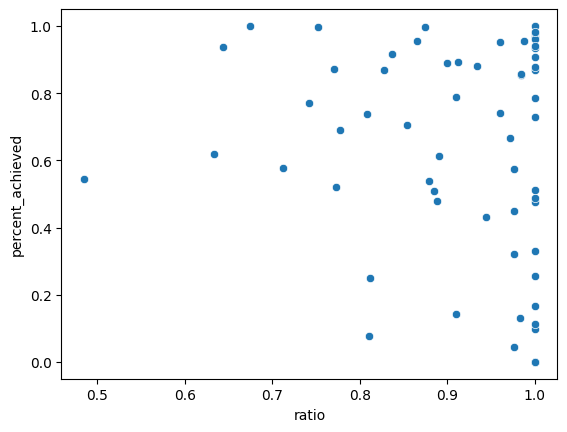

In [104]:
sns.scatterplot(data=synth_data[synth_data["baseline_difference"] <= 0], x = "ratio", y = "percent_achieved")